In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import igviz as ig
from node2vec import Node2Vec
from gensim.models import KeyedVectors
import seaborn as sns
import matplotlib.pyplot as plt
import src.visualize as vis
from src.visualize import visualize_celllevel_graph
import sys
sys.path.append('./src/')
sys.path.append('./src/submodules/CeSpGRN/src/')
from src.preprocessing import construct_celllevel_graph
from plotly.subplots import make_subplots

%load_ext autoreload
%autoreload 2

# import src.preprocessing as pre
# import src.visualize as vis
# pio.renderers.default = "png"

from src import models, training
from torch_geometric.nn import GAE
import torch
import os

/nethome/mbafna6/miniconda3/envs/CeSpGRN/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Clarify evaluation on seqFISH+ Mouse Visual Cortex

In [2]:
raw_data_path = "./data/seqFISH/"
data_name="seqfish"
baseline_name="DeepLinc"
studyname="withsplit0.1_withgenefeats_withpenalty_120epochs"

preprocess_output_path = f"./out/{data_name}/1_preprocessing_output/"
training_output_path = f"./out/{data_name}/2_training_output/"
evaluation_output_path = f"./out/{data_name}/3_evaluation_output/"

In [3]:
starting_df = pd.read_csv(os.path.join(raw_data_path,f"{data_name}_dataframe.csv"))

celllevel_adj, edges = construct_celllevel_graph(starting_df, 5, get_edges=True)

sim_fig = visualize_celllevel_graph(starting_df, gene="X",title="", edge_trace=edges, publication=True)
sim_fig.update_layout(
    plot_bgcolor="white"
)
sim_fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=False, ticks='outside')
sim_fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=False,ticks='outside')
sim_fig.update_coloraxes(showscale=False)
sim_fig.update_traces(marker=dict(color='gray'))
sim_fig.show()

## Clarify Test Performance vs. Baselines

In [4]:
split=0.3

clarify_metrics_seqfish_df = pd.read_csv(os.path.join(evaluation_output_path, f"metrics_{split}_old.csv"))[["Epoch", "CLARIFY Test AP", "CLARIFY Test ROC"]]
clarify_metrics_seqfish_df[f"{baseline_name} Test AP"] = np.load(f"./benchmark/deeplinc/{data_name}/test_ap_scores_{split}.npy")
clarify_metrics_seqfish_df[f"{baseline_name} Test ROC"] = np.load(f"./benchmark/deeplinc/{data_name}/test_roc_scores_{split}.npy")

figs = vis.visualize_metrics(clarify_metrics_seqfish_df, baseline_name, data_name, split)

for fig in figs:
    fig.show()

In [5]:
from scipy.stats import ranksums

def visualize_metrics_testsplits(data_name,baseline_name,metric):
    edge_mask_fig = go.Figure()
    clarify_medians = []
    deeplinc_medians = []
    pvalues = []
    for i, split in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
        clarify_vals = []
        deeplinc_vals = []

        for trial in range(1,6):
            # if os.path.exists(f"./benchmark/deeplinc/{data_name}/trial{trial}/fp0.0fn0.0test_{metric.lower()}_scores_{split}.npy"):

            # if os.path.exists(os.path.join(evaluation_output_path,  f"triallast{trial}_fp0.0_fn0.0_withsplit{split}_withgenefeats_withpenalty_120epochs_metrics_{split}_old.csv")):
            clarify_df = pd.read_csv(os.path.join(evaluation_output_path, f"triallast{trial}_fp0.0_fn0.0_withsplit{split}_withgenefeats_withpenalty_120epochs_metrics_{split}.csv"))
            clarify_results = clarify_df[f"CLARIFY Test {metric}"]
            deeplinc_results = np.load(f"./benchmark/deeplinc/{data_name}/trial{trial}/fp0.0fn0.0test_{metric.lower()}_scores_{split}.npy")
            for epoch in [100,110,120]:
                clarify_vals.append(clarify_results.iloc[epoch-1])
                deeplinc_vals.append(deeplinc_results[epoch-1])

        _,pval = ranksums(x=clarify_vals, y=deeplinc_results, alternative='greater') # since alternative hypothesis is "greater" the distribution underlying x is stochastically greater than the distribution underlying y.
        pvalues.append(pval)
        edge_mask_fig.add_trace(
            go.Box(name=split, y=clarify_vals, fillcolor = "#d14078", line=dict(color="black",width=1),opacity=0.7, showlegend=False, boxpoints=False, offsetgroup=1, width=0)
        )
        edge_mask_fig.add_trace(
            go.Box(name=split, y=deeplinc_vals, fillcolor = "#345c72", line=dict(color="black",width=1),opacity=0.7, showlegend=False, boxpoints=False, offsetgroup=2, width=0)
        )
        
        clarify_medians.append(np.median(clarify_vals))
        deeplinc_medians.append(np.median( deeplinc_vals))

    edge_mask_fig.add_trace(
        go.Scatter(x=[0.1, 0.3, 0.5, 0.7, 0.9],y=clarify_medians, marker=dict(color = "#d14078",line=dict(width=0,color='black')),
                    name="Clarify",opacity=0.9),
    ) 
    edge_mask_fig.add_trace(
        go.Scatter(x=[0.1, 0.3, 0.5, 0.7, 0.9],y=deeplinc_medians, marker=dict(color = "#345c72", line=dict(width=0,color='black')),
                    name=baseline_name,opacity=0.9)
    ) 

    xaxistitle = "Test Edge Ratio"
    yaxistitle = metric
    edge_mask_fig.update_yaxes(rangemode="tozero")
    edge_mask_fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, ticks='outside',tickfont=dict( size=17, color='black'))
    edge_mask_fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,ticks='outside',tickfont=dict( size=17, color='black'))
    edge_mask_fig.update_layout(
        title=f"({data_name.upper()}) {yaxistitle} vs. {xaxistitle}",
        xaxis_title=xaxistitle,
        yaxis_title=yaxistitle,
        legend_title="Model",
        width=800,
        height=600,
        boxmode='group',
        plot_bgcolor='white'
    )
    return edge_mask_fig, pvalues


difftestsplits_fig,pvalues = visualize_metrics_testsplits(data_name,baseline_name, "AP")
difftestsplits_fig.show()
pvalues

[4.120151647314232e-10,
 1.476174706451255e-10,
 1.476174706451255e-10,
 1.476174706451255e-10,
 1.544358920330764e-10]

# Clarify Embedding Results/Evaluation

## Load in Data

In [6]:
celllevel_data, genelevel_data = training.create_pyg_data(preprocess_output_path, split=None)
data = (celllevel_data, genelevel_data)

data

(Data(x=[1597, 125], edge_index=[2, 7985], y=[1597, 1597]),
 Data(x=[71865, 64], edge_index=[2, 1819947], y=[3233925]))

## Load in Clarify Model

In [7]:
def build_clarifyGAE_pytorch(data, hyperparams = None):
    num_cells, num_cellfeatures = data[0].x.shape[0], data[0].x.shape[1]
    num_genes, num_genefeatures = data[1].x.shape[0], data[1].x.shape[1]
    hidden_dim = hyperparams["concat_hidden_dim"] // 2
    num_genespercell = hyperparams["num_genespercell"]

    cellEncoder = models.GraphEncoder(num_cellfeatures, hidden_dim)
    geneEncoder = models.SubgraphEncoder(num_features=num_genefeatures, hidden_dim=hidden_dim, num_vertices = num_cells, num_subvertices = num_genespercell)
    
    multiviewEncoder = models.MultiviewEncoder(SubgraphEncoder = geneEncoder, GraphEncoder = cellEncoder)
    gae = GAE(multiviewEncoder)

    return gae


hyperparameters = {
    "num_genespercell": 45,
    "concat_hidden_dim": 64,
    "optimizer" : "adam",
    "criterion" : torch.nn.BCELoss(),
    "num_epochs": 400
}

trained_gae = build_clarifyGAE_pytorch(data, hyperparameters)
trained_gae.load_state_dict(torch.load(os.path.join(training_output_path,f'{studyname}_trained_gae_model.pth')))
trained_gae.eval()

GAE(
  (encoder): MultiviewEncoder(
    (encoder_g): SubgraphEncoder(
      (conv1): GCNConv(64, 32)
      (conv2): GCNConv(32, 32)
      (linear): Linear(in_features=1440, out_features=32, bias=True)
    )
    (encoder_c): GraphEncoder(
      (conv1): GCNConv(125, 32)
      (conv2): GCNConv(32, 32)
    )
  )
  (decoder): InnerProductDecoder()
)

## Get Clarify Embeddings

In [8]:
cell_level_encoder = trained_gae.encoder.encoder_c
gene_level_encoder = trained_gae.encoder.encoder_g
z, z_c, z_g, gene_embeddings = trained_gae.encode(data[0].x,data[1].x, data[0].edge_index, data[1].edge_index)
z.shape, z_c.shape, z_g.shape, gene_embeddings.shape

(torch.Size([1597, 64]),
 torch.Size([1597, 32]),
 torch.Size([1597, 32]),
 torch.Size([71865, 32]))

In [9]:
expanded_z_c = torch.repeat_interleave(z_c, 45, dim=0)
combined_gene_embeddings = torch.cat([expanded_z_c,gene_embeddings],dim=1)
combined_gene_embeddings.shape

torch.Size([71865, 64])

# Spatial Domain Visualization using Clarify Embeddings

In [10]:
from umap import UMAP
from sklearn.cluster import KMeans

spatial_domain_predictions = KMeans(n_clusters=6, random_state=0).fit_predict(z_c.detach().numpy())

spatial_domain_predictions.shape

(1597,)

In [11]:
full_cell_df = pd.read_csv(os.path.join(raw_data_path,f"{data_name}_dataframe.csv"))
full_cell_df["domain"] = spatial_domain_predictions.astype(int).astype(str)
np.unique(full_cell_df["domain"] )
cells_fig = visualize_celllevel_graph(full_cell_df, gene="domain", title="Spatial Domain Visualization", publication=False)
cells_fig.update_layout(coloraxis_colorbar_x=1)
cells_fig.show()


# Visualize Cell-Level Spatial Refinement of Clarify Embeddings

SpearmanrResult(correlation=0.7191971155988375, pvalue=0.0)
SpearmanrResult(correlation=0.2521997620030433, pvalue=0.0)


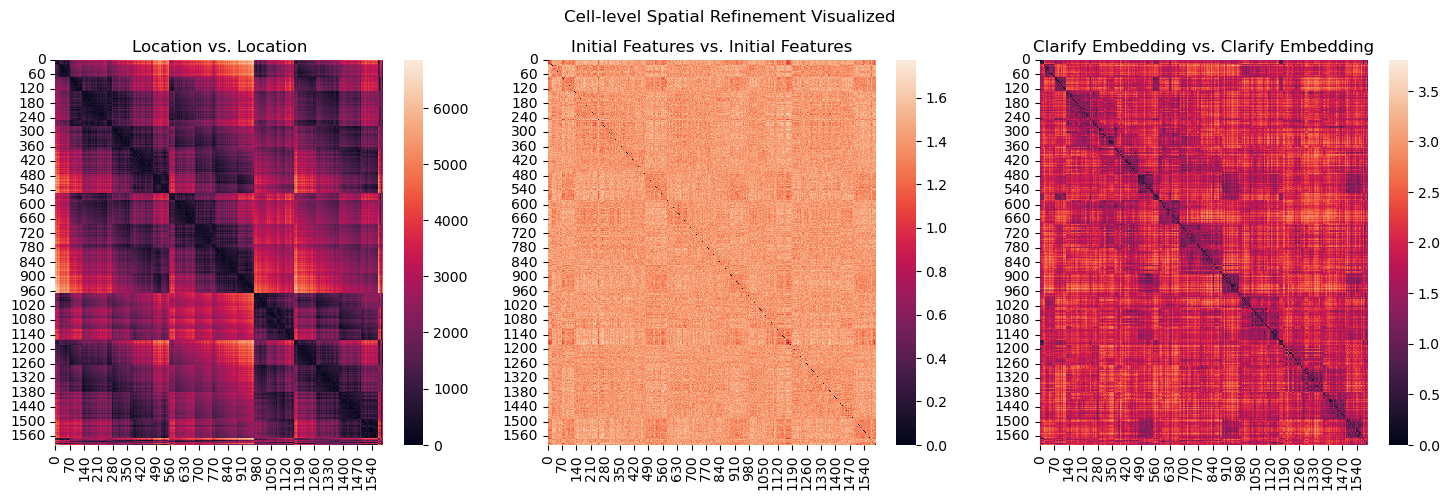

In [12]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import spearmanr, wilcoxon
from scipy.linalg import block_diag


def visualize_spatial_refinement_heatmaps(initial_features, raw_embeddings, coordinates, type="Cell", data_name="seqfish"):
    
    location_heatmap = euclidean_distances(coordinates,coordinates)
    embedding_heatmap = euclidean_distances(raw_embeddings,raw_embeddings)
    initial_heatmap = euclidean_distances(initial_features,initial_features)

    mask = np.triu_indices(initial_heatmap.shape[0], k=1)


    if data_name == "seqfish":
        one_block = np.ones(shape=(60,60))
        block_list = [one_block for _ in range(26)]
        block_list.append(np.ones(shape=(37,37)))
        mask = block_diag(*block_list).astype(bool)
    elif data_name == "merfish":
        one_block = np.ones(shape=(75,75))
        block_list = [one_block for _ in range(26)]
        block_list.append(np.ones(shape=(50,50)))
        mask = block_diag(*block_list).astype(bool)
    elif data_name == "scmultisim_final":
        one_block = np.ones(shape=(60,60))
        block_list = [one_block for _ in range(20)]
        mask = block_diag(*block_list).astype(bool)
    else:
        print("invalid data name")
    
    
    # print(mask.shape)

    print(spearmanr(location_heatmap[mask], embedding_heatmap[mask]))
    print(spearmanr(location_heatmap[mask], initial_heatmap[mask]))

    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18,5))
    fig.suptitle(f'{type}-level Spatial Refinement Visualized')
    axes[0].set_title(f'Location vs. Location')
    axes[1].set_title(f'Initial Features vs. Initial Features')
    axes[2].set_title(f'Clarify Embedding vs. Clarify Embedding')
    axes[0].set_yticks((0, len(initial_heatmap)), minor=False)
    
    sns.heatmap(location_heatmap, ax = axes[0])
    sns.heatmap(initial_heatmap, ax = axes[1])
    sns.heatmap(embedding_heatmap, ax = axes[2])
    
    
    return fig


locations= pd.read_csv(os.path.join(raw_data_path, "coord.csv")).values

cell_spatial_refinement = visualize_spatial_refinement_heatmaps(data[0].x, z_c.detach().numpy(), locations)

cell_spatial_refinement.show()

# Evaluate Gene-Level Spatial Refinement of Clarify Embeddings

In [23]:
num_genespercell = 45

if data_name == "seqfish":
    num_cells = 1597
elif data_name == "merfish":
    num_cells = 2000
elif data_name == "scmulti_sim":
    num_cells = 1200

celllevel_weightage = 0.4

weighted_combined_gene_embeddings = np.sum(torch.stack([celllevel_weightage * expanded_z_c, (1-celllevel_weightage) * gene_embeddings],dim=0).detach().numpy(), axis=0)


### Initial input gene features projected (baseline)

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)


components = pd.DataFrame(pca.fit_transform(data[1].x.detach().numpy()))

cellnumbers = []

num_cells_visualized = 10

for i in range(num_cells):
    val = f'Cell{i}'
    for j in range(45):
        cellnumbers.append(val)

components["Cell #"] = cellnumbers

components = components[:45*num_cells_visualized]

px.scatter(components, x=0,y=1, color="Cell #", title="PCA on Initial Gene Features (unrefined)", width=800, height=600, color_discrete_sequence=px.colors.qualitative.Prism)

### PCA visualization to assess the spatial and GLOBAL structure preservation of Clarify Embeddings

In [27]:
components = pd.DataFrame(pca.fit_transform(weighted_combined_gene_embeddings))

cellnumbers = []

for i in range(num_cells):
    val = f'Cell{i}'
    for j in range(num_genespercell):
        cellnumbers.append(val)

components["Cell #"] = cellnumbers

components = components[:45*num_cells_visualized]

px.scatter(components, x=0,y=1, color="Cell #", title="PCA of Clarify Gene-level embeddings (refined)",  width=800, height=600, color_discrete_sequence=px.colors.qualitative.Prism)

### UMAP Visualization to assess the spatial and LOCAL structure preservation of Clarify Embeddings

In [21]:
import umap

def project_genes(embeddings, num_cells, num_genespercell, type):
    cellnumbers = []
    gae_gene_embeddings = None

    if type == "None":
        for i in range(num_cells):
            val = f'Cell{i}'
            for j in range(num_genespercell):
                cellnumbers.append(val)

        gae_gene_embeddings = embeddings[:num_genespercell*num_cells]
        print(f"Selected {gae_gene_embeddings.shape[0]} out of {embeddings.shape[0]} genes")

        
    elif type == "pool":
        for i in range(num_cells):
            val = f'Cell{i}'
            cellnumbers.append(val)
            
        gae_gene_embeddings = embeddings[:num_cells, :]
    #    print(f"Selected {gae_gene_embeddings.shape[0]} out of {embeddings.shape[0]} cells")
    elif type == "concat":
        for i in range(num_cells):
            val = f'Cell{i}'
            cellnumbers.append(val)
            
        gae_gene_embeddings = embeddings[:num_genespercell*num_cells, :]
        print(gae_gene_embeddings.shape)
        gae_gene_embeddings = np.reshape(gae_gene_embeddings, (gae_gene_embeddings.shape[0]//num_genespercell, gae_gene_embeddings.shape[1] * num_genespercell))
        

    assert gae_gene_embeddings is not None

    umap_manifold = umap.UMAP(n_neighbors=num_cells, random_state=42).fit(gae_gene_embeddings)

    df = pd.DataFrame({"UMAP1":umap_manifold.embedding_[:, 0], "UMAP2":umap_manifold.embedding_[:, 1], "Cell #":cellnumbers})

    return df
  
num_cells_visualized = 10
num_genespercell = 45


pred_grnumap_df= project_genes(weighted_combined_gene_embeddings, num_cells=num_cells_visualized, num_genespercell=num_genespercell, type="None")

display(pred_grnumap_df)
px.scatter(pred_grnumap_df, x="UMAP1",y="UMAP2", color="Cell #", title="UMAP of Clarify Gene-level Embeddings (refined)",  width=800, height=600, color_discrete_sequence=px.colors.qualitative.Prism)

Selected 450 out of 71865 genes


UMAP1      UMAP2 Cell #
0    3.756825 -13.195716  Cell0
1    3.176574 -15.253050  Cell0
2    3.190001 -15.093586  Cell0
3    2.926867 -14.936908  Cell0
4   -1.738356 -15.987788  Cell0
..        ...        ...    ...
445 -1.579192  10.061425  Cell9
446 -0.876377  11.242375  Cell9
447 -1.011966   9.965099  Cell9
448 -1.422840  11.146111  Cell9
449 -0.693535  11.329516  Cell9

[450 rows x 3 columns]